# IMPETUS - Feature Engineering Pipeline

**Progetto**: Sistema di raccomandazione training (Push/Maintain/Deload)  
**Autore**: Alessandro Ambrosio  
**Università**: Università degli studi di Salerno - Laurea Triennale Informatica
**Corso**: Fondamenti di Intelligena Artificiale

---

## Obiettivo Modulo

Costruire dataset temporale con feature ingegnerizzate per alimentare **due pipeline predittive**:

1. **Pipeline A - Performance Score** (0-100)
   - Obiettivo: Quantificare capacità performativa utente
   - Feature chiave: Load progression, Volume, TSB positivo, Consistency
   - Target: `performance_score`

2. **Pipeline B - Injury Risk Score** (0-100)
   - Obiettivo: Quantificare rischio infortunio
   - Feature chiave: ACWR spike, Fatigue alta, TSB negativo, RPE variability
   - Target: `injury_risk_score`

**Decisione finale**: Bilanciamento trade-off performance vs safety

---

## Pipeline Completa

<pre>
Input: workout_sets.csv (450k set) + banister_daily.csv
   ↓
[1. Aggregazione Giornaliera]
   ↓
[2. Grid Temporale Completa] (riempi rest days)
   ↓
[3. Rolling Windows 7/14/28d] (load, volume, RPE)
   ↓
[4. Merge Banister] (TSB, fitness, fatigue)
   ↓
[5. ACWR Calculation] (spike detection)
   ↓
[6. Target Generation] (performance_score + injury_risk_score)
   ↓
Output: impetus_features_full.csv (~60 colonne)
</pre>


---

## Feature Overview

| Categoria | Feature Esempi | Pipeline A | Pipeline B |
|-----------|----------------|------------|------------|
| **Load Temporale** | load_mean_7d, load_mean_28d |  Alta |  Media |
| **Volume** | volume_sum_7d, volume_sum_14d |  Alta |  Media |
| **Banister** | TSB, fitness, fatigue |  Media |  Alta |
| **Spike Detection** | ACWR, spike_flag, volume_WoW_pct |  Bassa |  **CRITICA** |
| **RPE** | rpe_mean_7d, rpe_std_7d |  Media |  Alta |
| **Consistency** | consistency_28d, weeks_active |  Alta |  Media |

**Overlap**: ~80% feature condivise (efficienza computazionale)  
**Specializzazione**: Feature importances diverse per obiettivo

---

##  Output Attesi

- Dataset finale: **~12,000 righe** (1000 utenti x ~12 settimane medie)
- Feature totali: **~60 colonne**
- Target: 2 score continui (0-100)
- Split temporale: Train (primi 70% giorni) | Val (15%) | Test (ultimi 15%)

---

##  Prerequisiti

- CSV generati da generatore sintetico (EDA completata)
- Validazioni integrità superate (no leakage, missing <2%)

## **CELLA 2 - Setup Python**

In [1]:
"""
═══════════════════════════════════════════════════════════════
SETUP ENVIRONMENT
═══════════════════════════════════════════════════════════════
Import librerie e configurazione ambiente
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurazione visualizzazioni
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# Palette colori professionale
COLORS = {
    'primary': '#2E86AB',    # Blu
    'secondary': '#A23B72',  # Viola
    'success': '#06A77D',    # Verde
    'warning': '#F18F01',    # Arancione
    'danger': '#C73E1D'      # Rosso
}

# Seed per riproducibilità
np.random.seed(42)

print("=" * 80)
print("IMPETUS - FEATURE ENGINEERING")
print("=" * 80)
print("Setup completato")
print(f"   Pandas: {pd.__version__}")
print(f"   NumPy: {np.__version__}")
print(f"   Matplotlib: {plt.matplotlib.__version__}")
print("\nAmbiente pronto per elaborazione")


IMPETUS - FEATURE ENGINEERING
Setup completato
   Pandas: 2.2.2
   NumPy: 2.0.2
   Matplotlib: 3.10.0

Ambiente pronto per elaborazione


##**CELLA 3 - Markdown: Caricamento Dati**

---

## SEZIONE 1: Caricamento e Preparazione Dati

### Obiettivo
Caricare CSV grezzi e preparare per aggregazione temporale.

### Input Files
- `workout_sets.csv`: Set-level data (granularità massima)
- `banister_daily.csv`: Serie temporali Fitness/Fatigue/Performance
- `users.csv`: Anagrafica utenti (experience_label è input da STATUS)
- `workouts.csv`: Metadata sessioni

### Operazioni
1. Caricamento CSV con pandas
2. Parsing colonne date (datetime dtype)
3. Merge `experience_label` da users → workout_sets
4. Rename colonne Banister (`F`→`fitness`, `D`→`fatigue`, `P`→`performance`)
5. Calcolo TSB (Training Stress Balance) = fitness - fatigue


##**CELLA 4 - Caricamento Dati (con Auto-Detect)**

In [4]:
"""
═══════════════════════════════════════════════════════════════
CARICAMENTO DATI
═══════════════════════════════════════════════════════════════
Carica CSV dalla sezione Files (upload manuale utente)
"""

print("=" * 80)
print("CARICAMENTO DATI")
print("=" * 80)

import os

# ═══════════════════════════════════════════════════════════════
# Verifica presenza file
# ═══════════════════════════════════════════════════════════════

required_files = [
    'workout_sets.csv',
    'banister_daily.csv',
    'users.csv',
    'workouts.csv'
]

print("\nVerifica file in /content/...")

missing_files = [f for f in required_files if not os.path.exists(f)]

if missing_files:
    print("\n(ERR) FILE MANCANTI:")
    for f in missing_files:
        print(f"   - {f}")
    print("\nAZIONE RICHIESTA:")
    print("   1. Apri pannello Files (icona cartella a sinistra)")
    print("   2. Trascina i 4 CSV nella root /content/")
    print("   3. Ri-esegui questa cella")
    raise FileNotFoundError(f"Missing files: {missing_files}")

print("(OK) Tutti i file presenti\n")

# ═══════════════════════════════════════════════════════════════
# Caricamento CSV
# ═══════════════════════════════════════════════════════════════

print("Caricamento in pandas...")

workout_sets = pd.read_csv('workout_sets.csv')
banister = pd.read_csv('banister_daily.csv')
users = pd.read_csv('users.csv')
workouts = pd.read_csv('workouts.csv')

# Parse date
workout_sets['date'] = pd.to_datetime(workout_sets['date'])
banister['date'] = pd.to_datetime(banister['date'])
workouts['date'] = pd.to_datetime(workouts['date'])

# Merge experience_label in workout_sets
workout_sets = workout_sets.merge(
    users[['userid', 'experience_label']],
    on='userid',
    how='left'
)

# Setup Banister: rename + merge experience + calcola TSB
banister = banister.rename(columns={
    'F': 'fitness',
    'D': 'fatigue',
    'P': 'performance'
})
banister = banister.merge(
    users[['userid', 'experience_label']],
    on='userid',
    how='left'
)
banister['TSB'] = banister['fitness'] - banister['fatigue']

# ═══════════════════════════════════════════════════════════════
# Info Summary
# ═══════════════════════════════════════════════════════════════

print("\n(OK) DATI CARICATI E PREPARATI")
print("=" * 80)

summary_df = pd.DataFrame({
    'Dataset': ['workout_sets', 'banister', 'users', 'workouts'],
    'Righe': [
        len(workout_sets),
        len(banister),
        len(users),
        len(workouts)
    ],
    'Colonne': [
        workout_sets.shape[1],
        banister.shape[1],
        users.shape[1],
        workouts.shape[1]
    ],
    'Memory (MB)': [
        workout_sets.memory_usage(deep=True).sum() / 1024**2,
        banister.memory_usage(deep=True).sum() / 1024**2,
        users.memory_usage(deep=True).sum() / 1024**2,
        workouts.memory_usage(deep=True).sum() / 1024**2
    ]
})

print("\n" + summary_df.round(2).to_string(index=False))

# Range temporale
date_min = workout_sets['date'].min()
date_max = workout_sets['date'].max()
days_span = (date_max - date_min).days

print(f"\nRange Temporale:")
print(f"   Inizio: {date_min.date()}")
print(f"   Fine:   {date_max.date()}")
print(f"   Span:   {days_span} giorni ({days_span/365:.1f} anni)")

# Distribuzione experience
exp_dist = workout_sets.groupby('experience_label').size().sort_values(ascending=False)
print(f"\nDistribuzione Experience Level (set):")
for level, count in exp_dist.items():
    pct = count / len(workout_sets) * 100
    print(f"   {level:12s}: {count:7,} set ({pct:5.1f}%)")

# Validazioni rapide
missing_exp = workout_sets['experience_label'].isna().sum()
missing_dates = workout_sets['date'].isna().sum()

print(f"\nValidazioni:")
print(f"   experience_label missing: {missing_exp} ({'OK' if missing_exp == 0 else '!'})")
print(f"   Date NaT: {missing_dates} ({'OK' if missing_dates == 0 else '!'})")
print(f"   TSB calcolato: {'OK' if 'TSB' in banister.columns else '!'}")

print("\n" + "=" * 80)


CARICAMENTO DATI

Verifica file in /content/...
(OK) Tutti i file presenti

Caricamento in pandas...

(OK) DATI CARICATI E PREPARATI

     Dataset  Righe  Colonne  Memory (MB)
workout_sets 553054       17       164.98
    banister 107707       12        15.11
       users   1000       16         0.36
    workouts  47332       10        10.09

Range Temporale:
   Inizio: 2025-02-04
   Fine:   2026-02-01
   Span:   362 giorni (1.0 anni)

Distribuzione Experience Level (set):
   Intermediate: 306,338 set ( 55.4%)
   Beginner    : 186,088 set ( 33.6%)
   Advanced    :  60,628 set ( 11.0%)

Validazioni:
   experience_label missing: 0 (OK)
   Date NaT: 0 (OK)
   TSB calcolato: OK



## **CELLA 5 - Markdown: Aggregazione Strategia**

---

##  SEZIONE 2: Aggregazione Temporale

### Razionale: Perché Day-Level?

**Problema**: Granularità set-level (450k righe) è troppo fine per:
- Rolling windows significativi (troppo noise)
- Interpretabilità (single set non rappresenta giornata)
- Efficienza computazionale (calcoli pesanti)

**Soluzione**: Aggregazione giornaliera per utente

| Granularità | Pro | Con | Scelta IMPETUS |
|-------------|-----|-----|----------------|
| **Set-level** | Massimo dettaglio | Noise alto, pesante | (NO) |
| **Day-level** | Balance dettaglio/stabilità | - | (OK) **Scelta** |
| **Week-level** | Smooth, leggero | Perde variabilità intra-settimana | (NO) (dopo rolling) |

### Aggregazioni Calcolate

Per ogni `(userid, date)` coppia:

#### Load (Intensità)
- `load_mean`: Media carichi (indicatore intensità giornaliera)
- `load_std`: Deviazione standard (variabilità intra-session)
- `load_max`: Massimo (picco intensità)
- `load_sum`: Somma totale (volume grezzo carico)

#### Reps (Volume Ripetizioni)
- `reps_total`: Somma reps (volume totale giorno)
- `reps_mean`: Media reps/set (indicatore schema)

#### RPE (Fatica Percepita)
- `rpe_mean`: RPE medio giornaliero
- `rpe_std`: Variabilità RPE (consistency)
- `rpe_max`: RPE picco (sforzo massimo percepito)

#### Metadata
- `num_sets`: Conteggio set eseguiti
- `volume_daily`: Approssimazione volume = load_sum × reps_mean

### Rilevanza per Pipeline

| Feature | Pipeline A (Performance) | Pipeline B (Injury) |
|---------|--------------------------|---------------------|
| `load_mean` | (OK) Trend progressione | (OK) Baseline carico |
| `load_std` | (!) Bassa | (OK) Variabilità = inconsistency risk |
| `volume_daily` | (OK) **ALTA** (work capacity) | (OK) Media (sovraccarico) |
| `rpe_mean` | (OK) Media (sforzo) | (OK) Alta (fatigue proxy) |
| `rpe_std` | (!) Bassa | (OK) **ALTA** (erraticità = risk) |


##**CELLA 6 - Aggregazione + Grafico Validazione**


AGGREGAZIONE GIORNALIERA

Aggregazione completata:
   Input (set-level):  553,054 righe
   Output (day-level): 41,621 righe
   Riduzione:          92.5%
   Colonne generate:   13

Statistiche Aggregazioni:
       load_mean  volume_daily  rpe_mean  num_sets
count   41621.00      41621.00  41621.00  41621.00
mean       42.49       5033.40      4.45     13.29
std        14.75       2429.60      0.43      4.25
min        15.30        598.00      2.82      3.00
25%        28.81       3240.36      4.15     10.00
50%        42.38       4558.30      4.44     13.00
75%        51.00       6324.00      4.73     16.00
max       122.79      21234.53      6.42     31.00


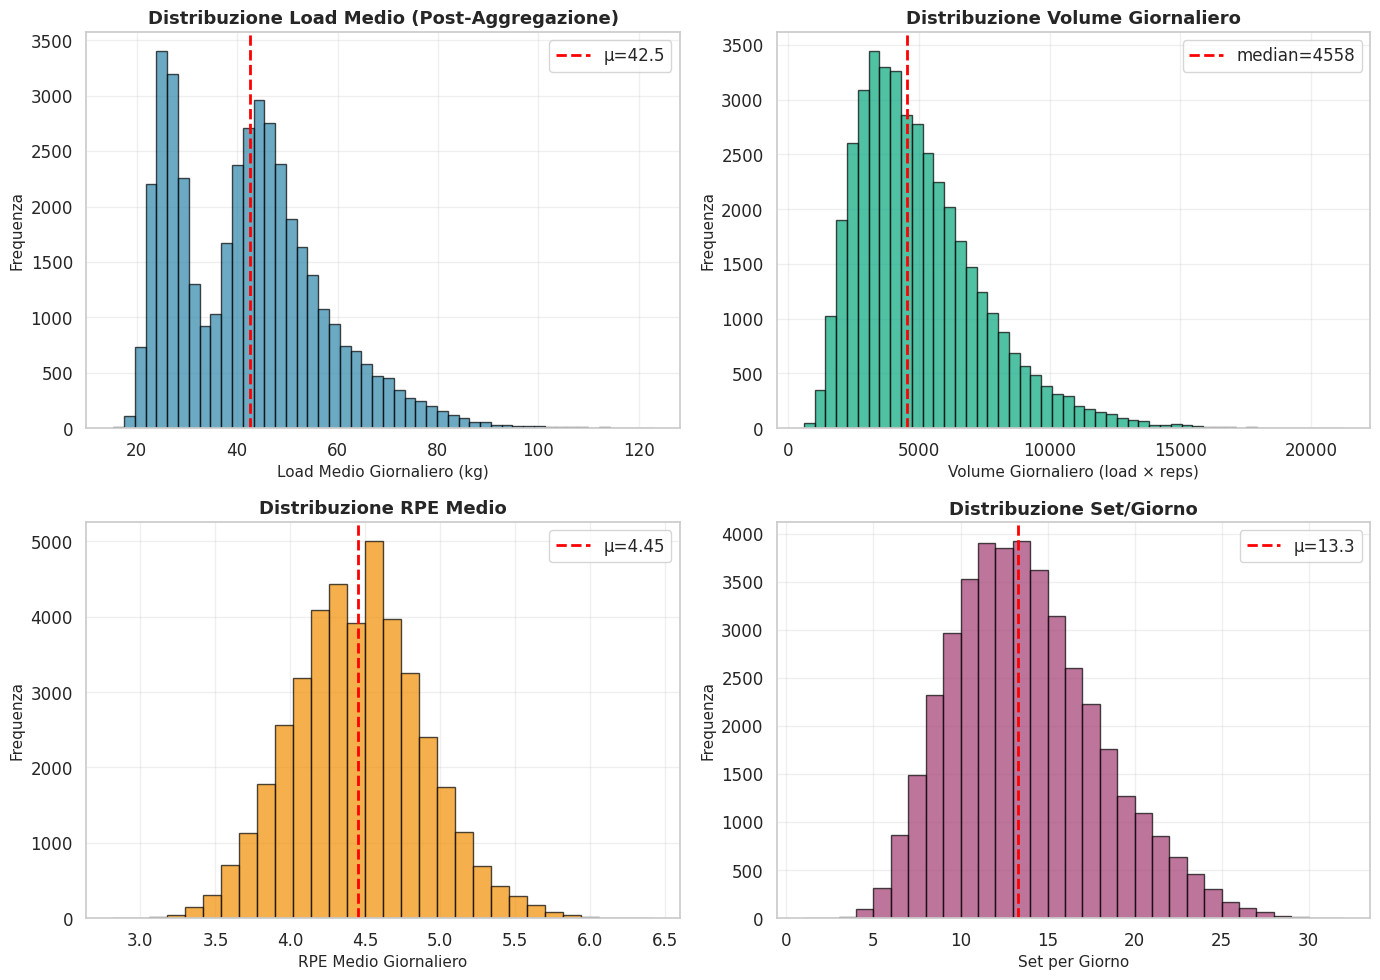


Interpretazione:
   - Load medio: 42.5 kg (coerente con mixed population)
   - Volume medio: 4558 (variabilità alta attesa)
   - RPE medio: 4.45 (range sostenibile 4-5)
   - Set/giorno: 13.3 (somma tutti workout del giorno)



In [6]:
"""
═══════════════════════════════════════════════════════════════
AGGREGAZIONE: SET-LEVEL → DAY-LEVEL
═══════════════════════════════════════════════════════════════
Riduce granularità da singoli set a statistiche giornaliere
"""

print("\n" + "=" * 80)
print("AGGREGAZIONE GIORNALIERA")
print("=" * 80)

# ═══════════════════════════════════════════════════════════════
# Aggregazione per (userid, date)
# ═══════════════════════════════════════════════════════════════

daily_agg = workout_sets.groupby(['userid', 'date']).agg({
    'load_done_kg': ['mean', 'std', 'max', 'sum'],
    'reps_done': ['sum', 'mean'],
    'rpe_done': ['mean', 'std', 'max'],
    'set_index': 'count'
}).reset_index()

# Flatten colonne
daily_agg.columns = [
    'userid', 'date',
    'load_mean', 'load_std', 'load_max', 'load_sum',
    'reps_total', 'reps_mean',
    'rpe_mean', 'rpe_std', 'rpe_max',
    'num_sets'
]

# Calcola volume giornaliero
daily_agg['volume_daily'] = daily_agg['load_sum'] * daily_agg['reps_mean']

print(f"\nAggregazione completata:")
print(f"   Input (set-level):  {len(workout_sets):,} righe")
print(f"   Output (day-level): {len(daily_agg):,} righe")
print(f"   Riduzione:          {(1 - len(daily_agg)/len(workout_sets))*100:.1f}%")
print(f"   Colonne generate:   {len(daily_agg.columns)}")

# ═══════════════════════════════════════════════════════════════
# Statistiche descrittive
# ═══════════════════════════════════════════════════════════════

print(f"\nStatistiche Aggregazioni:")
stats_agg = daily_agg[['load_mean', 'volume_daily', 'rpe_mean', 'num_sets']].describe()
print(stats_agg.round(2).to_string())

# ═══════════════════════════════════════════════════════════════
# GRAFICO VALIDAZIONE: Distribuzioni Post-Aggregazione
# ═══════════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Load medio
axes[0, 0].hist(daily_agg['load_mean'].dropna(), bins=50,
                 color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[0, 0].axvline(daily_agg['load_mean'].mean(), color='red',
                    linestyle='--', linewidth=2, label=f'μ={daily_agg["load_mean"].mean():.1f}')
axes[0, 0].set_xlabel('Load Medio Giornaliero (kg)')
axes[0, 0].set_ylabel('Frequenza')
axes[0, 0].set_title('Distribuzione Load Medio (Post-Aggregazione)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Volume giornaliero
axes[0, 1].hist(daily_agg['volume_daily'].dropna(), bins=50,
                 color=COLORS['success'], edgecolor='black', alpha=0.7)
axes[0, 1].axvline(daily_agg['volume_daily'].median(), color='red',
                    linestyle='--', linewidth=2, label=f'median={daily_agg["volume_daily"].median():.0f}')
axes[0, 1].set_xlabel('Volume Giornaliero (load × reps)')
axes[0, 1].set_ylabel('Frequenza')
axes[0, 1].set_title('Distribuzione Volume Giornaliero', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# RPE medio
axes[1, 0].hist(daily_agg['rpe_mean'].dropna(), bins=30,
                 color=COLORS['warning'], edgecolor='black', alpha=0.7)
axes[1, 0].axvline(daily_agg['rpe_mean'].mean(), color='red',
                    linestyle='--', linewidth=2, label=f'μ={daily_agg["rpe_mean"].mean():.2f}')
axes[1, 0].set_xlabel('RPE Medio Giornaliero')
axes[1, 0].set_ylabel('Frequenza')
axes[1, 0].set_title('Distribuzione RPE Medio', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Numero set per giorno
axes[1, 1].hist(daily_agg['num_sets'], bins=range(1, int(daily_agg['num_sets'].max())+2),
                 color=COLORS['secondary'], edgecolor='black', alpha=0.7)
axes[1, 1].axvline(daily_agg['num_sets'].mean(), color='red',
                    linestyle='--', linewidth=2, label=f'μ={daily_agg["num_sets"].mean():.1f}')
axes[1, 1].set_xlabel('Set per Giorno')
axes[1, 1].set_ylabel('Frequenza')
axes[1, 1].set_title('Distribuzione Set/Giorno', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretazione:")
print(f"   - Load medio: {daily_agg['load_mean'].mean():.1f} kg (coerente con mixed population)")
print(f"   - Volume medio: {daily_agg['volume_daily'].median():.0f} (variabilità alta attesa)")
print(f"   - RPE medio: {daily_agg['rpe_mean'].mean():.2f} (range sostenibile 4-5)")
print(f"   - Set/giorno: {daily_agg['num_sets'].mean():.1f} (somma tutti workout del giorno)")

print("\n" + "=" * 80)
